In [1]:
from basicsr.trainer import Surgeon, SurgeonTrainer
from basicsr.data import restore_volume, semi_synthetic_creation, \
     generate_raw_data, generate_zs_dataset, adjust_contrast, denoised_semi_synthetic_creation
from basicsr.model_train import trainer_train,restore
from easydict import EasyDict
import os
import tifffile
from oct.utils import generate_dataset, stack
import cv2
from basicsr.utils.dataset import normalize, resize
import numpy as np


# SSAI_PATH = "C:/Users/rkulothu/Documents/Repos/SSAI-3D"
SSAI_PATH = "/Users/ramachandrank/Repos/SSAI-3D/"


In [2]:
raw_tif_path = f"{SSAI_PATH}/raw_data/oct.tif"
project_depth = 7
data_save_path = "data"
results_save_path = "results"

In [3]:
def create_projected_data_with_1step_slide(raw_tif_pth, save_pth, project_depth = 4, projected_dir = "projected_data"):

    raw_data = tifffile.imread(raw_tif_pth)
    slices, height, width = raw_data.shape
    raw_data = normalize(raw_data)

    projected_pth = os.path.join(save_pth, projected_dir)
    os.makedirs(projected_pth, exist_ok = True)

    # Create convolved images from projections of project_depth slice sets
    for slice_idx in range(slices -  project_depth + 1):
        avg_slice = np.average(raw_data[slice_idx:slice_idx + project_depth], 0)
        avg_slice = normalize(avg_slice)
        tifffile.imwrite(os.path.join(projected_pth, f'{slice_idx}.tiff'), avg_slice)

create_projected_data_with_1step_slide(raw_tif_path, data_save_path, project_depth = 4, projected_dir = "projected_data")

In [ ]:
from matplotlib import pyplot as plt
from oct.utils import filter
from scipy import signal

ground_truth_dir = "gt"
low_quality_dir = "lq"


def downsample_and_resize(image, dr_h, dr_w):
    # Downsample the image
    downsampled_image = image[::dr_h, ::dr_w]
    
    # Resize the image to the original size
    resized_image = cv2.resize(downsampled_image, (image.shape[1], image.shape[0]))
    # resized_image = downsampled_image
    return resized_image

def create_synthetic_data_from_slices(input_pth, output_pth,
    kernel_num = 3, dr_h = 2, dr_w = 2, blur_width = False, blur_height = False):
    kernel_lst = []
    res_lst = [[] for _ in range(kernel_num)]
    gt_lst = [[] for _ in range(kernel_num)]
    
    for idx, std in enumerate(np.arange(3,101,2)):
        if idx >= kernel_num:
            break
        std_width = 0
        std_height = 0
        if blur_width:
            std_width = std
        if blur_height:
            std_height = std
        kernel_lst.append(filter.g_filter(51, std_width, std_height))
    
    for i in range(len(kernel_lst)):
        plt.imshow(kernel_lst[i], cmap='jet', extent=[-51//2, 51//2, -51//2, 51//2])
        plt.colorbar(label='Intensity')
        plt.title(f"Gaussian Filter ({i})")
        plt.show()

    gt_pth = os.path.join(output_pth, ground_truth_dir)
    lq_pth = os.path.join(output_pth, low_quality_dir)
    os.makedirs(gt_pth, exist_ok = True)
    os.makedirs(lq_pth, exist_ok = True)
    files = os.listdir(input_pth)

    for file in files:
        raw_slice = tifffile.imread(os.path.join(input_pth, file))
        for idx, k in enumerate(kernel_lst):
            conved_slice = signal.fftconvolve(raw_slice, k, mode = 'same')
            conved_slice = downsample_and_resize(conved_slice, dr_h, dr_w)
            res_lst[idx].append(conved_slice)
            gt_lst[idx].append(raw_slice)
            assert conved_slice.shape == raw_slice.shape

    lqstacks = [np.stack(s) for s in res_lst]
    gtstacks = [np.stack(s) for s in gt_lst]
    for idx, stack in enumerate(lqstacks):
        lqstack = normalize(stack)
        gtstack = normalize(gtstacks[idx])
        for slice_idx, lq_slice in enumerate(lqstack):
            gt_slice = gtstack[slice_idx]
            tifffile.imwrite(os.path.join(gt_pth, f'{idx}_{slice_idx}.tiff'), gt_slice)
            tifffile.imwrite(os.path.join(lq_pth, f'{idx}_{slice_idx}.tiff'), lq_slice)

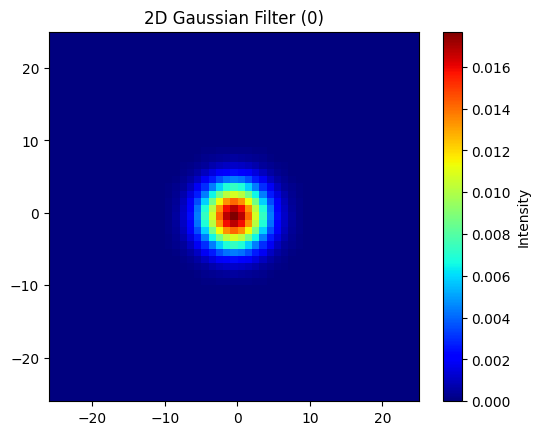

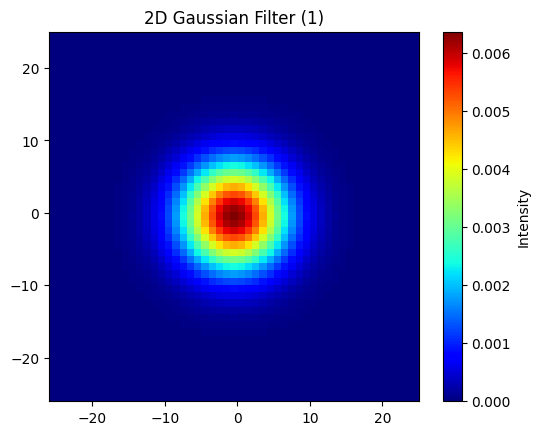

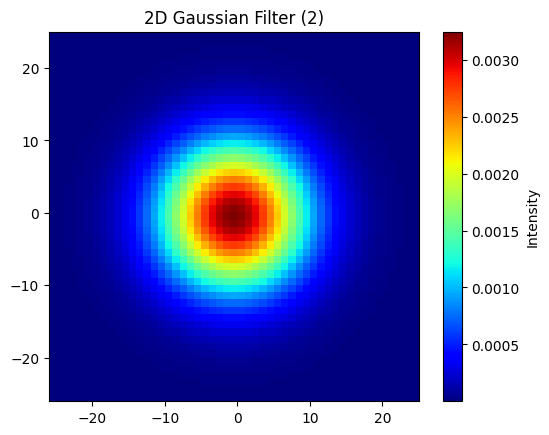

In [7]:
create_synthetic_data_from_slices("", "", 3, 2, True, True)

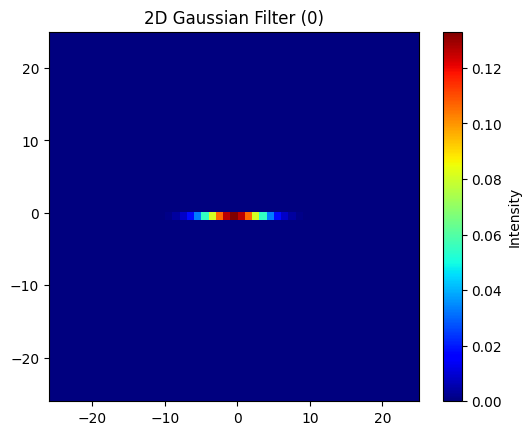

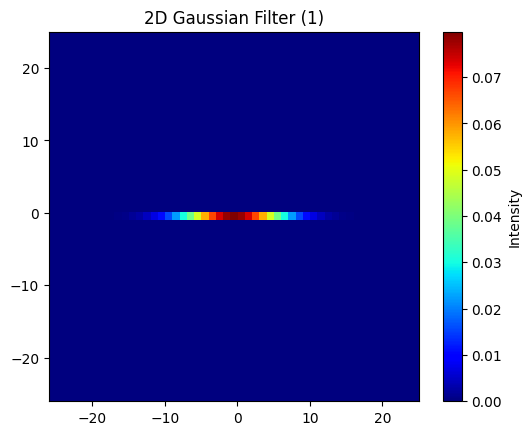

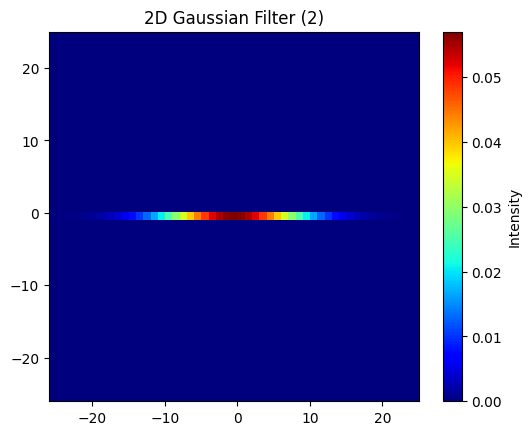

In [8]:
create_synthetic_data_from_slices("", "", 3, 2, True, False)

In [ ]:
create_synthetic_data_from_slices("", "", 3, 2, True, False)

In [23]:
image = tifffile.imread(raw_tif_path)
dr_image = downsample_and_resize(image[124], 1, 2)
tifffile.imwrite("dr_image.tiff", dr_image)
tifffile.imwrite("image.tiff", image[124])

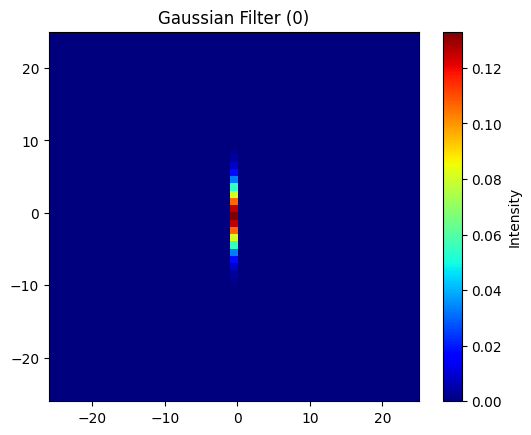

In [5]:
create_synthetic_data_from_slices(f"{data_save_path}/projected_data", data_save_path, 1, 1, 2, False, True)

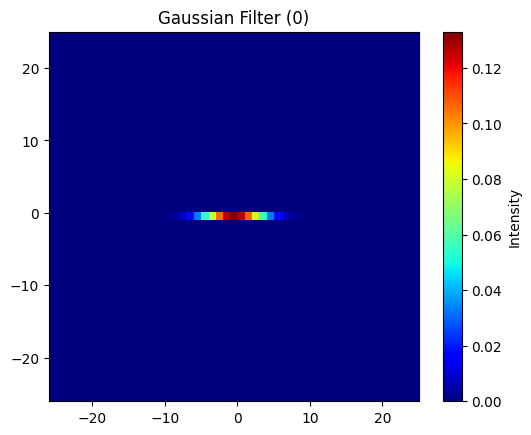

In [6]:
create_synthetic_data_from_slices(f"{data_save_path}/projected_data", data_save_path, 1, 1, 2, True, False)